In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!pip install transformers

In [ ]:
!pip install pytorch_pretrained_bert pytorch-nlp

In [ ]:
import re
import sys
import itertools
import numpy as np
import random as rn
import matplotlib.pyplot as plt
import torch
from pytorch_pretrained_bert import BertModel
from torch import nn
from torchnlp.datasets import imdb_dataset
from pytorch_pretrained_bert import BertTokenizer
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import Adam
from torch.nn.utils import clip_grad_norm_
from IPython.display import clear_output

In [ ]:
rn.seed(321)
np.random.seed(321)
torch.manual_seed(321)
torch.cuda.manual_seed(321)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
from transformers import *

class GlobalBERT:
    def __init__(self):
        self.model_class, self.tokenizer_class, self.pretrained_weights = (BertModel, BertTokenizer, 'bert-large-cased')

        self.tokenizer = self.tokenizer_class.from_pretrained(self.pretrained_weights)
        self.model = self.model_class.from_pretrained(self.pretrained_weights, output_hidden_states=True)

    def from_sentence_to_embedding(self, text, use_special_tokens=True):
        raise Exception

class BERT11Sense(GlobalBERT):
    def __init__(self):
        super().__init__()

    def from_sentence_to_embedding(self, text, use_special_tokens=True):
        input_ids = torch.tensor([self.tokenizer.encode(text,
                                                   add_special_tokens=use_special_tokens)])
        outputs = self.model(input_ids)[2]
        return (outputs[12][0]).detach().numpy()
       
       
bb = BERT11Sense()


bb.from_sentence_to_embedding("hello darling")

array([[ 0.53891903,  1.0641247 ,  0.06854141, ...,  0.49491456,
        -0.45627293,  0.91966647],
       [ 0.19274706, -1.5048006 , -0.03996131, ...,  0.22079   ,
        -0.8769878 ,  0.8757973 ],
       [-0.8659395 , -1.022461  , -0.8534421 , ...,  0.3458095 ,
        -0.1420723 ,  0.37167025],
       [ 0.09797782, -0.00276929,  0.04643975, ...,  0.36611277,
        -0.05931362, -0.04601835]], dtype=float32)

In [ ]:
cd drive/My Drive/Colab Notebooks/experiments

/content/drive/My Drive/Colab Notebooks/experiments


In [ ]:
import pandas as pd
df = pd.read_csv('data/VUA/VUA_formatted.csv', encoding="ISO-8859-1")

In [ ]:
df.head(3)

,text_idx,sentence_idx,verb,sentence,verb_idx,label
0,a1h-fragment06,117,reflect,He was President of FISA ( Federation Internat...,31,1
1,a1h-fragment06,118,encounter,Most athletes first encountered him as a voice...,3,0
2,a1h-fragment06,118,bellow,Most athletes first encountered him as a voice...,9,1


In [ ]:
#embeddings = [np.mean(bb.from_sentence_to_embedding(k), axis = 0) for k in df["sentence"].values]

In [ ]:
#embeddings = np.array(embeddings)
#embeddings.shape

In [ ]:
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report

In [ ]:
from sklearn.model_selection import train_test_split

X = df.sentence.values
y = df.label.values

X_train, X_val, y_train, y_val =\
    train_test_split(X, y, test_size=0.1, random_state=2020)

In [ ]:
# Load test data - TroFi
import pandas as pd
test_data = pd.read_csv('data/Datasets/en_lcc_new.csv')

# Keep important columns
test_data = test_data[['sentence', 'polarity', 'intensity', 'source_concept', 'target_concept']]

# Display 5 samples from the test data
test_data.sample(5)

,sentence,polarity,intensity,source_concept,target_concept
1718,The U.S. will similarly bring a new set of p...,POSITIVE,0.0,MOVEMENT,ELECTIONS
6531,EXPOSED: The between and the coming food crisis,POSITIVE,1.0,PORTAL,CONTROL_OF_GUNS
14565,The monetary is not set according to the need...,NaN,NaN,NaN,BUREAUCRACY
9535,"Oct 01, 2007; ... Introduction In the past twe...",NaN,NaN,ENERGY,MIGRATION
14537,"That's 1.03 teradollars, or roughly ten grand ...",NaN,NaN,NaN,TAXPAYERS


In [ ]:
#test_data.label.unique()
#test_data.label.value_counts()

In [ ]:
import nltk
# Uncomment to download "stopwords"
nltk.download("stopwords")
from nltk.corpus import stopwords

def text_preprocessing(s):
    """
    - Lowercase the sentence
    - Change "'t" to "not"
    - Remove "@name"
    - Isolate and remove punctuations except "?"
    - Remove other special characters
    - Remove stop words except "not" and "can"
    - Remove trailing whitespace
    """
    s = s.lower()
    # Change 't to 'not'
    s = re.sub(r"\'t", " not", s)
    # Remove @name
    s = re.sub(r'(@.*?)[\s]', ' ', s)
    # Isolate and remove punctuations except '?'
    s = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r' \1 ', s)
    s = re.sub(r'[^\w\s\?]', ' ', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Remove stopwords except 'not' and 'can'
    s = " ".join([word for word in s.split()
                  if word not in stopwords.words('english')
                  or word in ['not', 'can']])
    # Remove trailing whitespace
    s = re.sub(r'\s+', ' ', s).strip()
    
    return s

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
X_train

array(['The user tells the analyst what the problems are , and the analyst decides , at least in broad terms , what the user requires .',
       "I do n't think I did .",
       'But she had given up all hope of Joss Barnet returning that evening and nothing else in the world mattered .',
       ...,
       'It would seem that , despite the costs involved , they should consider investing in the very detailed digital data ( Pinpoint Address Code ( PAC ) ) provided by Pinpoint Analysis Ltd .',
       "I 'll try not to fall down the step when I go .",
       'Sorge leant across and finished his coffee before continuing .'],
      dtype=object)

In [ ]:
y_train

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
X_val

array(["Whether the life sentence is regarded as a sufficient denunciation in society depends on the public 's perception of what life imprisonment means : if it is widely believed that it results in an average of nine years ' imprisonment , the effect will be somewhat blunted .",
       "But I mean , you would n't have thought that er Lilly , I mean , she had no weight on her or anything like",
       'Straightening up beside the dog , he looked where she was looking , and blinked .',
       ..., 'I want to watch .',
       'In summary , then , as fig. 8.1 shows , many of the issues raised by this review of geographic information handling in the four potential application fields are essentially complementary to those discussed in the part on methodological developments .',
       "Designing clothes for Carnega was all very well and I made a good living at it I wo n't deny but I wanted to be free to do my own thing Ì¢åÛåÓ and to have my own name on the labels ."],
      dtype=object)

In [ ]:
y_val

array([0, 0, 0, ..., 0, 0, 1])

In [ ]:
#TF-IDF vectorizer - vectorize text data beforecreating the model

%%time
from sklearn.feature_extraction.text import TfidfVectorizer

# Preprocess text
X_train_preprocessed = np.array([text_preprocessing(text) for text in X_train])
X_val_preprocessed = np.array([text_preprocessing(text) for text in X_val])

# Calculate TF-IDF
tf_idf = TfidfVectorizer(ngram_range=(1, 3),
                         binary=True,
                         smooth_idf=False)
X_train_tfidf = tf_idf.fit_transform(X_train_preprocessed)
X_val_tfidf = tf_idf.transform(X_val_preprocessed)

CPU times: user 45.2 s, sys: 5.01 s, total: 50.3 s
Wall time: 50.3 s


In [ ]:
# Hyperparameter Tuning

from sklearn.model_selection import StratifiedKFold, cross_val_score

def get_auc_CV(model):
    """
    Return the average AUC score from cross-validation.
    """
    # Set KFold to shuffle data before the split
    kf = StratifiedKFold(5, shuffle=True, random_state=1)

    # Get AUC scores
    auc = cross_val_score(
        model, X_train_tfidf, y_train, scoring="roc_auc", cv=kf)

    return auc.mean()

Best alpha:  4.2


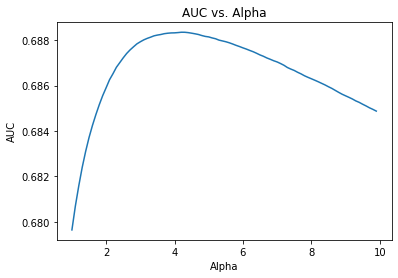

In [ ]:
# MultinomialNB - find the best alpha parameter that gives the highest CV AUC score

from sklearn.naive_bayes import MultinomialNB

res = pd.Series([get_auc_CV(MultinomialNB(i))
                 for i in np.arange(1, 10, 0.1)],
                index=np.arange(1, 10, 0.1))

best_alpha = np.round(res.idxmax(), 2)
print('Best alpha: ', best_alpha)

plt.plot(res)
plt.title('AUC vs. Alpha')
plt.xlabel('Alpha')
plt.ylabel('AUC')
plt.show()

In [ ]:
# Evaluation on validation set - model'saccuracy rate and AUC score on validation set

from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

AUC: 0.7178
Accuracy: 72.36%


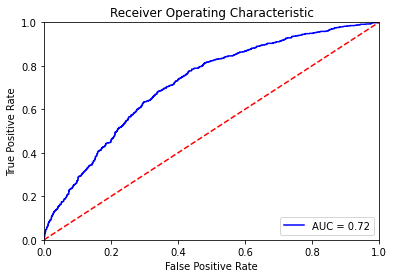

In [ ]:
# Compute predicted probabilities
nb_model = MultinomialNB(alpha=1.8)
nb_model.fit(X_train_tfidf, y_train)
probs = nb_model.predict_proba(X_val_tfidf)

# Evaluate the classifier
evaluate_roc(probs, y_val)

# This is the baseline accuracy score before finetuning

In [ ]:
# BERT Finetuning

In [ ]:
# Some processing before Finetuning

def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [ ]:
# Print sentence 0
print('Original: ', X[0])
print('Processed: ', text_preprocessing(X[0]))

Original:  He was President of FISA ( Federation Internationale des Societes d'Aviron ) , the world governing body , for 30 years ; and most of this body 's attitudes and practices reflect the force of his strict , but genial personality .
Processed:  He was President of FISA ( Federation Internationale des Societes d'Aviron ) , the world governing body , for 30 years ; and most of this body 's attitudes and practices reflect the force of his strict , but genial personality .


In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased', do_lower_case=True)

# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [ ]:
# Concatenate train data and test data
all_sentences = df['sentence']

# Encode our concatenated data
encoded_sentences = [bb.tokenizer.encode(sent, add_special_tokens=True) for sent in all_sentences]

# Find the maximum length
max_len = max([len(sent) for sent in encoded_sentences])
print('Max length: ', max_len)

Max length:  135


In [ ]:
# Specify `MAX_LEN`
MAX_LEN = 64

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([X[0]])[0].squeeze().numpy())
print('Original: ', X[0])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Original:  He was President of FISA ( Federation Internationale des Societes d'Aviron ) , the world governing body , for 30 years ; and most of this body 's attitudes and practices reflect the force of his strict , but genial personality .
Token IDs:  [101, 2002, 2001, 2343, 1997, 27424, 2050, 1006, 4657, 21339, 4078, 18341, 2015, 1040, 1005, 20704, 9711, 2078, 1007, 1010, 1996, 2088, 8677, 2303, 1010, 2005, 2382, 2086, 1025, 1998, 2087, 1997, 2023, 2303, 1005, 1055, 13818, 1998, 6078, 8339, 1996, 2486, 1997, 2010, 9384, 1010, 2021, 8991, 4818, 6180, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Tokenizing data...


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [ ]:
%%time
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: user 38 µs, sys: 0 ns, total: 38 µs
Wall time: 41.7 µs


In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=3):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [ ]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=10, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [ ]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla V100-SXM2-16GB


In [ ]:
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=3)
train(bert_classifier, train_dataloader, val_dataloader, epochs=3, evaluation=True)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.590936   |     -      |     -     |   2.88   
   1    |   40    |   0.558226   |     -      |     -     |   2.73   
   1    |   60    |   0.600244   |     -      |     -     |   2.75   
   1    |   80    |   0.537821   |     -      |     -     |   2.75   
   1    |   100   |   0.550844   |     -      |     -     |   2.72   
   1    |   120   |   0.557179   |     -      |     -     |   2.77   
   1    |   140   |   0.505282   |     -      |     -     |   2.80   
   1    |   160   |   0.561908   |     -      |     -     |   2.75   
   1    |   180   |   0.515214   |     -      |     -     |   2.74   
   1    |   200   |   0.518864   |     -      |     -     |   2.75   
   1    |   220   |   0.544727   |     -      |     -     |   2.73   
   1    |   240   |   0.518033   |     -      |     -     |   2.74   


In [ ]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [ ]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

AUC: 0.7807
Accuracy: 74.74%


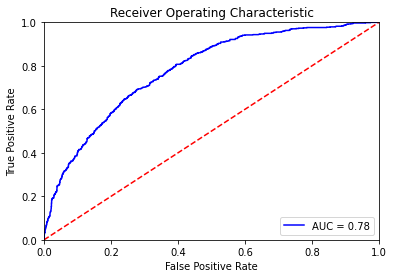

In [ ]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, val_dataloader)

# Evaluate the Bert classifier
evaluate_roc(probs, y_val)

In [ ]:
preds = probs[:, 1]
y_pred = np.where(preds >= 0.5, 1, 0)

#importing confusion matrix
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_val, y_pred)
print('Confusion Matrix\n')
print(confusion)

#importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_val, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_val, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_val, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_val, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_val, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_val, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_val, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_val, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_val, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_val, y_pred, average='weighted')))

Confusion Matrix

[[1392  246]
 [ 338  336]]

Accuracy: 0.75

Micro Precision: 0.75
Micro Recall: 0.75
Micro F1-score: 0.75

Macro Precision: 0.69
Macro Recall: 0.67
Macro F1-score: 0.68

Weighted Precision: 0.74
Weighted Recall: 0.75
Weighted F1-score: 0.74


In [ ]:
def get_predictions(model, data_loader):
  model.eval()
  
  sentence_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["sentence_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      sentence_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return sentence_texts, predictions, prediction_probs, real_values

In [ ]:
from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_val, y_pred, target_names=['Literal','Metaphorical']))


Classification Report

              precision    recall  f1-score   support

     Literal       0.80      0.85      0.83      1638
Metaphorical       0.58      0.50      0.54       674

    accuracy                           0.75      2312
   macro avg       0.69      0.67      0.68      2312
weighted avg       0.74      0.75      0.74      2312



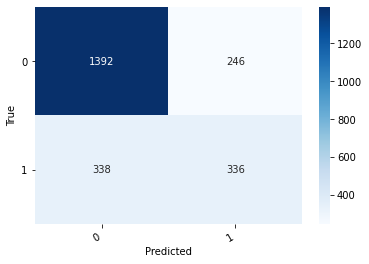

In [ ]:
import seaborn as sns
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True')
  plt.xlabel('Predicted');

cm = confusion_matrix(y_val, y_pred)
#df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(cm)

#Predictions on Test Set

In [ ]:
test_data.sample(5)

In [ ]:
en_lcc = pd.read_csv("data/Datasets/en_lcc_new.csv")

In [ ]:
en_lcc.sample(5)

In [ ]:
import seaborn as sns
sns.countplot(en_lcc.label)
plt.xlabel('Sentences nature');

In [ ]:
en_lcc.label.value_counts()

In [ ]:
# Run `preprocessing_for_bert` on the test set
print('Tokenizing data...')
test_inputs, test_masks = preprocessing_for_bert(test_data.sentence.astype(str))

# Create the DataLoader for our test set
test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

#Predictions

In [ ]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, test_dataloader)

# Get predictions from the probabilities
threshold = 0.4
preds = np.where(probs[:, 1] > threshold, 1, 0)

# Number of tweets predicted non-negative
print("Number of tweets predicted non-metaphorical: ", preds.sum())

In [ ]:
output = pd.DataFrame({'sentence': test_data.sentence,
                       'correct_label': en_lcc.label,
                       'prediction': preds,
                       'polarity': en_lcc.polarity,
                       'intensity': en_lcc.intensity,
                       'source_concept': en_lcc.source_concept,
                       'target_concept': en_lcc.target_concept})
output.to_csv('submission.csv', index=False)

In [ ]:
predictions = pd.read_csv("submission.csv")

In [ ]:
predictions.head()

In [ ]:
predictions.shape

In [ ]:
final = predictions[(predictions['correct_label'] == predictions['prediction'])]

In [ ]:
final.shape

In [ ]:
correct_met = predictions[(predictions['correct_label'] == 1) & (predictions['prediction'] ==1)]

In [ ]:
correct_met.shape

In [ ]:
correct_met.to_csv("mohx_lcc_correct_metaphors.csv", index=False)

In [ ]:
correct_met = pd.read_csv("mohx_lcc_correct_metaphors.csv")

In [ ]:
correct_met.head()

In [ ]:
wrong_met = predictions[(predictions['correct_label'] == 1) & (predictions['prediction'] ==0)]

In [ ]:
wrong_met.shape

In [ ]:
wrong_met.to_csv("mohx_lcc_correct_metaphors.csv", index=False)

In [ ]:
wrong_met = pd.read_csv("mohx_lcc_correct_metaphors.csv")

In [ ]:
wrong_met.head()

In [ ]:
final_lit = predictions[(predictions['correct_label'] == 0) & (predictions['prediction'] ==0)]

In [ ]:
final_lit.shape

In [ ]:
!pip install sweetviz

In [ ]:
import sweetviz as sv
#You could specify which variable in your dataset is the target for your model creation. We can specify it using the target_feat parameter.
final_sweetviz = sv.analyze(correct_met)
final_sweetviz.show_html()

In [ ]:
import sweetviz as sv
#You could specify which variable in your dataset is the target for your model creation. We can specify it using the target_feat parameter.
final_sweetviz1 = sv.analyze(wrong_met)
final_sweetviz1.show_html()

In [ ]:
output = test_data[preds==1]
list(output.sample(100).sentence)

In [ ]:
class_names = ['Literal', 'Metaphorical']

In [ ]:
#TroFi - literal sentence
raw_text= "He was detained on June 23 , and for two weeks he was regularly assaulted by South African police"

In [ ]:
encoded_text = tokenizer.encode_plus(
  raw_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [ ]:
input_ids = encoded_text['input_ids'].to(device)
attention_mask = encoded_text['attention_mask'].to(device)

output = bert_classifier(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Sentence: {raw_text}')
print(f'Nature: {class_names[prediction]}')

In [ ]:
#TroFi - metaphorical sentence
raw_text2 = "Justin makes building products , cooling towers and boots "

In [ ]:
encoded_text2 = tokenizer.encode_plus(
  raw_text2,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [ ]:
input_ids = encoded_text2['input_ids'].to(device)
attention_mask = encoded_text2['attention_mask'].to(device)

output = bert_classifier(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Sentence: {raw_text2}')
print(f'Nature: {class_names[prediction]}')

In [ ]:
raw_text3 = "They also exert a fascination very much of their own as they slither round circuses and brush through old city gates , flashing arcs of lightning as they switch tracks on winter nights ."

In [ ]:
encoded_text3 = tokenizer.encode_plus(
  raw_text3,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [ ]:
input_ids = encoded_text3['input_ids'].to(device)
attention_mask = encoded_text3['attention_mask'].to(device)

output = bert_classifier(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Sentence: {raw_text3}')
print(f'Nature: {class_names[prediction]}')

In [ ]:
raw_text4 = "Eventually they will be replaced , but more than 60 years on they run with the rhythmic reliability of a Swiss watch ."

In [ ]:
encoded_text4 = tokenizer.encode_plus(
  raw_text4,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [ ]:
input_ids = encoded_text4['input_ids'].to(device)
attention_mask = encoded_text4['attention_mask'].to(device)

output = bert_classifier(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Sentence: {raw_text4}')
print(f'Nature: {class_names[prediction]}')

In [ ]:
raw_text5 = "Destined to run in Manchester , they will relieve traffic congestion and help to reduce the levels of carbon monoxide in the city centre , outlying suburbs and satellite towns of Bury , Altrincham , Salford , Oldham and Rochdale ."

In [ ]:
encoded_text5 = tokenizer.encode_plus(
  raw_text5,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [ ]:
input_ids = encoded_text5['input_ids'].to(device)
attention_mask = encoded_text5['attention_mask'].to(device)

output = bert_classifier(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Sentence: {raw_text5}')
print(f'Nature: {class_names[prediction]}')

In [ ]:
raw_text6 = "Triple mileage has struck another blow to the coupon market ."

In [ ]:
encoded_text6 = tokenizer.encode_plus(
  raw_text6,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [ ]:
input_ids = encoded_text6['input_ids'].to(device)
attention_mask = encoded_text6['attention_mask'].to(device)

output = bert_classifier(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Sentence: {raw_text6}')
print(f'Nature: {class_names[prediction]}')